In [19]:
import torch
torch.manual_seed(2)

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [20]:
class System(torch.nn.Module):
    def __init__(self, x0, horizon):
        self.x0 = x0
        self.horizon = horizon
          # Initialize heating state to 0.5 (OFF)

    def step(self, x,u_bin, d = None, neural = True, hard = False):
        """if d is not None:
            u = d[:, 0:+1, :] + u"""
        

        # x, u_bin, d : torch.Tensor of shape (B, 1, 1)

        """cond1 = (x > 3) & (u_bin < 0.5)
        cond2 = (x < -3) & (u_bin > 0.5)

        x = torch.where(
            cond1 | cond2,
            0.99 * x + u_bin - d,
            0.99 * x - d
        )"""
        beta = 10.0

        v1 = torch.relu(3 - x) + torch.relu(u_bin - 0.5)
        v2 = torch.relu(x + 3) + torch.relu(0.5 - u_bin)
        v3 = torch.zeros_like(x)

        scores = torch.cat([-beta*v1, -beta*v2, -beta*v3], dim=1)
        delta = torch.softmax(scores, dim=1)

        f1 = 0.99 * x + u_bin - d
        f2 = 0.99 * x + u_bin - d
        f3 = 0.99 * x - d

        f = torch.cat([f1, f2, f3], dim=1)

        x_next = (delta * f).sum(dim=1,keepdim=True)


        return x_next
    
    def rollout(self, controller, tau = 1,d = None, hard = False, neural = True):

        x = d[:,0:1,:] if d is not None else self.x0.clone()
        xs = x.clone()
        us = torch.zeros(xs.shape[0],1,1)
        self.us_soft = torch.zeros(xs.shape[0],1,1)



        for t in range(1,self.horizon-1):

            u_bin = controller(x,d[:,t:t+1,:],tau = tau,  hard = hard)
            x = self.step(x, u_bin,d[:,t:t+1,:], neural=neural, hard=hard)

            xs = torch.cat((xs, x), 1)
            us = torch.cat((us, u_bin), 1)

            if hard:
                self.us_soft = torch.cat((self.us_soft, controller.u_soft), 1)

        return xs, us
    
class Dataset():    
    def __init__(self, x0, horizon):
        self.x0 = x0
        self.horizon = horizon
        self.batch_size = self.x0.shape[0]

    def generate_data(self):
        d = torch.zeros((self.batch_size, self.horizon, 1))
        d = torch.zeros((self.batch_size, self.horizon, 1))
        #d[:, 0, :] = 5*torch.rand((self.batch_size, 1))
        d[:, 0, :] = 10

        # Sample one uniform value per batch in [0.3, 1.0]

        #u = 0.9 + 1.1*torch.rand((self.batch_size, 1, 1))   
        u = torch.rand((self.batch_size, 1, 1))*0.3
        
        d[:, 70:, :] = u  # Fill from time step 70 onward (inclusive)
         
        return d



In [21]:
class Controller(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # output logit
        )


    def forward(self, x,d, tau=1.0, hard=False):
        input = torch.cat((x,d), dim=2)
        u = self.net(input)
       
        return u
        

In [22]:
nb = 400

x0 = torch.zeros((nb,1,1))
#x0[0,0,0] = 10
x_target = 0

horizon = 200



sys = System(x0,horizon)

controller = Controller()
data = Dataset(x0, horizon)
d = data.generate_data()
test_d = data.generate_data()

tau_0 = 1.0
alpha = 0.995
tau_min = 1e-1

best_loss = float('inf')
best_params = None

num_epochs = 2000
log_epochs = num_epochs // 10
optimizer = torch.optim.Adam(controller.parameters(), lr=0.001) 

for epoch in range(num_epochs):
    optimizer.zero_grad()

    tau = max(tau_0 * (alpha ** epoch), tau_min)

    xs, us = sys.rollout(controller, tau = tau,d = d, hard = False, neural = True)

    loss = torch.mean((xs - x_target)**2) 

    loss.backward()
    optimizer.step()

    if epoch % log_epochs == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_params = controller.state_dict()

# Load the best parameters
controller.load_state_dict(best_params)
with torch.no_grad():
    x_log, u_log = sys.rollout(controller,tau = tau,d = test_d, hard=False)

loss = torch.mean((x_log- x_target)**2) 
print(f"Test Loss: {loss.item():.4f}")




Epoch 0, Loss: 57.6022
Epoch 200, Loss: 42.8628
Epoch 400, Loss: 44.1249
Epoch 600, Loss: 30.6169
Epoch 800, Loss: 28.2014
Epoch 1000, Loss: 27.0453
Epoch 1200, Loss: 27.4830
Epoch 1400, Loss: 26.8694
Epoch 1600, Loss: 26.6513
Epoch 1800, Loss: 27.1390
Test Loss: 26.9163


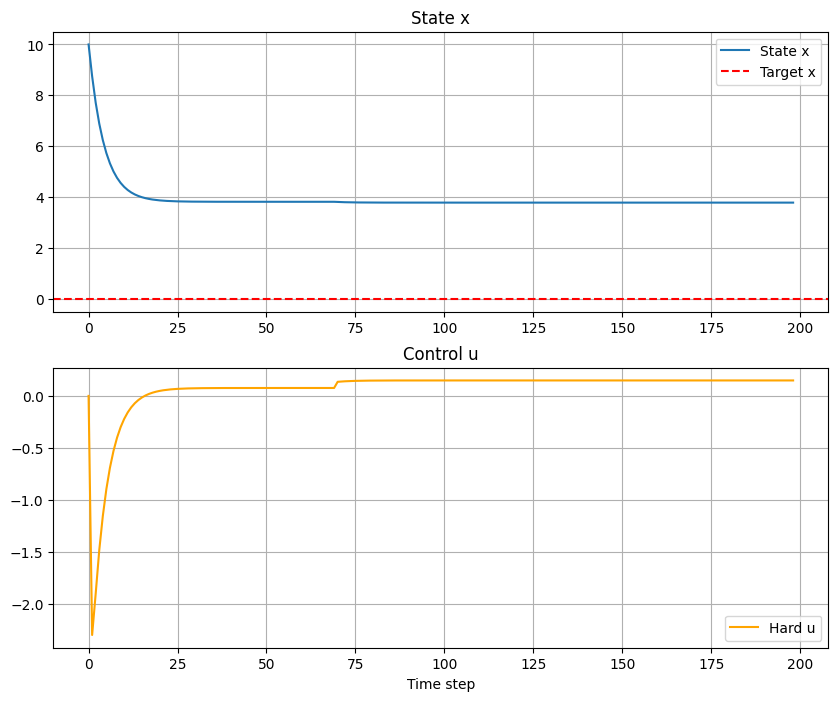

In [23]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(x_log[0,:,:].detach().numpy(), label='State x')
"""ax[0].plot(x_log[1,:,:].detach().numpy(), label='State x')
ax[0].plot(x_log[2,:,:].detach().numpy(), label='State x')"""
ax[0].axhline(y=x_target, color='r', linestyle='--', label='Target x')
ax[0].set_title('State x')

ax[0].legend()
ax[0].grid()

ax[1].plot(u_log[0,:,:].detach().numpy(), label='Hard u', color='orange')
ax[1].set_title('Control u')
ax[1].set_xlabel('Time step')


ax[1].legend()
ax[1].grid()